In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


In [7]:
# conversions
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}

sut_ct_label = {'combination long-haul truck':'combination truck',
                  'combination short-haul truck': 'combination truck',
                  'single unit short-haul truck': 'single unit truck',
                 'single unit long-haul truck': 'single unit truck'}

hauling_label = {'combination long-haul truck':'long-haul',
                  'combination short-haul truck': 'short-haul',
                  'single unit short-haul truck': 'short-haul',
                 'single unit long-haul truck': 'long-haul'}

#age bin related
age_bin = [-1, 1, 3, 5, 10, 15, 20, 31]
age_bin_label = ['age<=1', '1<age<=3', '3<age<=5', 
                 '5<age<=10', '10<age<=15', '15<age<=20', 'age>=20']
age_bin_order = {'age<=1':1, '1<age<=3':2, '3<age<=5':3, 
                 '5<age<=10':4, '10<age<=15':5, 
                 '15<age<=20':6, 'age>=20':7}

In [3]:
# load MOVES data
MOVES_data_path = 'RawData/MOVES/MOVES_VMT_fraction_with_fuel_com_only.csv'
MOVES_fleet = read_csv(MOVES_data_path)
print(MOVES_fleet.columns)

# load vius data
vius_data_path = 'RawData/US_VIUS_2021/vius_2021_puf_com_only_crosswalk.csv'
vius_fleet = read_csv(vius_data_path)
vius_fleet.head(5)

Index(['sourceTypeID', 'ageID', 'HPMSVtypeID', 'sourceTypeName',
       'HPMSVtypeName', 'sourceTypePopulation', 'ageFraction', 'modelYearID',
       'population_by_year', 'relativeMAR', 'weighted_vmt_rate',
       'vmt_fraction', 'fuelTypeID', 'stmyFraction', 'fuelTypeDesc'],
      dtype='object')


,ID,TABWEIGHT,REGSTATE,ACQUIREYEAR,ACQUISITION,AVGWEIGHT,BRAKES,BTYPE,BUSRELATED,CAB,...,TRUCKLOADPCT,TTYPE,VEHTYPE,WEIGHOUTPCT,VEH_CLASS_4,SHORT_HUAL,VEH_CLASS_SynthF,VEH_CLASS_SynthFirm,SUT_def,VEH_CLASS_MOVES
0,1,38.5,Montana,2011,Used,"100,001 to 130,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,Not applicable (see 'Applicable Vehicles'),"Flatbed, platform",Truck tractor,40,Class 7-8,1,HDT,HDT tractor,1,Combination short-haul truck
1,2,197.4,North Carolina,Not reported,Used,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,25,Container,Truck tractor,40,Class 7-8,1,HDT,HDT tractor,1,Combination short-haul truck
2,8,182.3,New Jersey,2009,Used,"50,001 to 60,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,Not applicable (see 'Applicable Vehicles'),"Flatbed, platform",Truck tractor,0,Class 7-8,1,HDT,HDT tractor,0,Combination short-haul truck
3,9,85.9,Louisiana,Not reported,Used,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,Not applicable (see 'Applicable Vehicles'),Dump,Truck tractor,Not applicable (see 'Applicable Vehicles'),Class 7-8,1,HDT,HDT tractor,1,Combination short-haul truck
4,10,240.2,Ohio,2019,New,"60,001 to 80,000 pounds",Air,Not applicable (see 'Applicable Vehicles'),Some commercial activity,Not applicable (see 'Applicable Vehicles'),...,82,"Flatbed, platform",Truck tractor,0,Class 7-8,0,HDT,HDT tractor,1,Combination long-haul truck


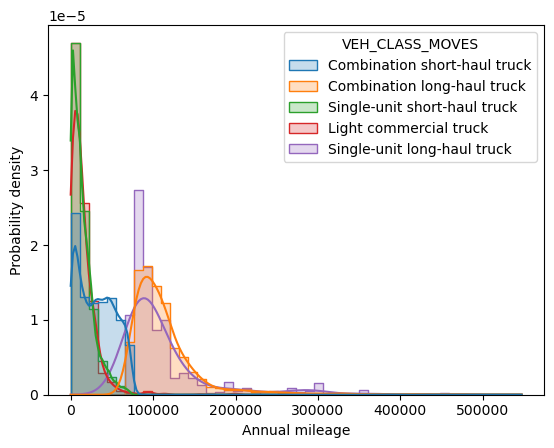

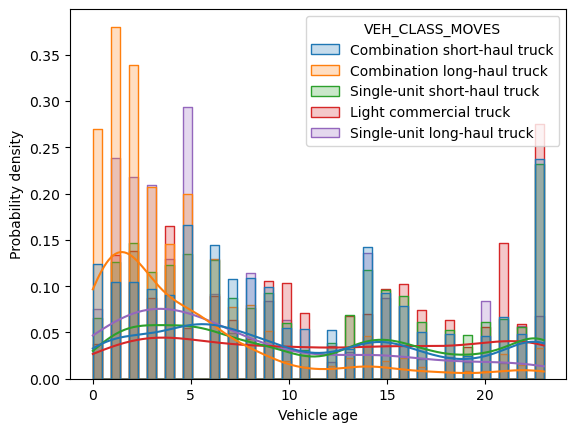

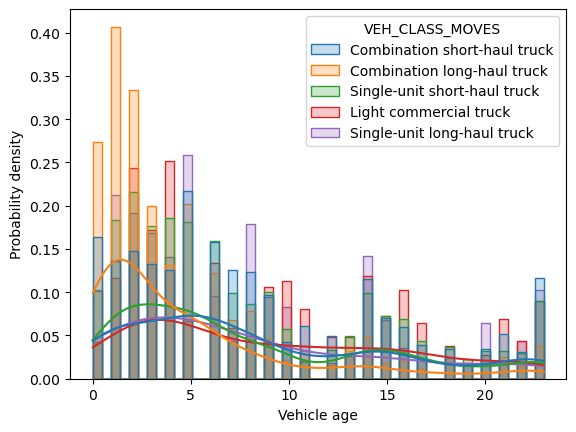

In [6]:
# post-process VIUS data

# weighted VMT
vius_fleet.loc[:, 'WGT_VMT'] = \
vius_fleet.loc[:, 'TABWEIGHT'] * vius_fleet.loc[:, 'MILESANNL']

# vehicle age
vius_fleet.loc[:, 'VEH_AGE'] = \
2021 - vius_fleet.loc[:, 'MODELYEAR']

vius_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(vius_fleet.loc[:, 'VEH_AGE'], 
       bins=age_bin, right=True, labels=age_bin_label)

MOVES_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(MOVES_fleet.loc[:, 'ageID'], 
       bins=age_bin, right=True, labels=age_bin_label)

sns.histplot(data=vius_fleet, 
             x="MILESANNL", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Annual mileage')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/annual_mileage_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_count_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'WGT_VMT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_VMT_VIUS.png', dpi = 300)
plt.show()

In [17]:
# check sample size
vius_sample_size_1 = vius_fleet.groupby(['VEH_CLASS_MOVES']).size()
print(vius_sample_size_1)
vius_sample_size_2 = vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN']).size()
vius_sample_size_2

VEH_CLASS_MOVES
Combination long-haul truck      4112
Combination short-haul truck     9033
Light commercial truck           1042
Single-unit long-haul truck       357
Single-unit short-haul truck    21674
dtype: int64


VEH_CLASS_MOVES               AGE_BIN   
Combination long-haul truck   age<=1        1313
                              1<age<=3       981
                              3<age<=5       614
                              5<age<=10      584
                              10<age<=15     264
                              15<age<=20     184
                              age>=20        172
Combination short-haul truck  age<=1         871
                              1<age<=3       742
                              3<age<=5       909
                              5<age<=10     1774
                              10<age<=15    1555
                              15<age<=20    1213
                              age>=20       1969
Light commercial truck        age<=1          62
                              1<age<=3       120
                              3<age<=5        92
                              5<age<=10      207
                              10<age<=15     175
                            

In [27]:
# compare veh count by MOVES source type

MOVES_fleet.head(5)
MOVES_count_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['sourceTypePopulation']].mean()
MOVES_count_by_st = MOVES_count_by_st.reset_index()
MOVES_count_by_st['sourceTypeName'] = \
MOVES_count_by_st['sourceTypeName'].str.lower()
print(MOVES_count_by_st['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['TABWEIGHT']].sum()
vius_count_by_st = vius_count_by_st.reset_index()
vius_count_by_st['VEH_CLASS_MOVES'] = \
vius_count_by_st['VEH_CLASS_MOVES'].str.lower()
vius_count_by_st.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_st.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_count_by_st.columns = ['Vehicle type', 'Count']
MOVES_count_by_st.loc[:, 'Source'] = 'MOVES'

vius_count_by_st.columns = ['Vehicle type', 'Count']
vius_count_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


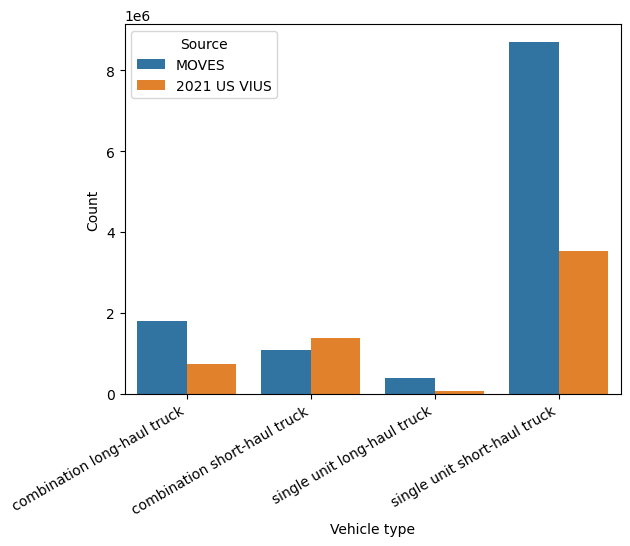

In [26]:
truck_count_comparison = \
pd.concat([MOVES_count_by_st, vius_count_by_st])
truck_count_comparison = \
truck_count_comparison.loc[truck_count_comparison["Vehicle type"] != 
'light commercial truck']
sns.barplot(truck_count_comparison, 
            x="Vehicle type", y="Count", hue="Source", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

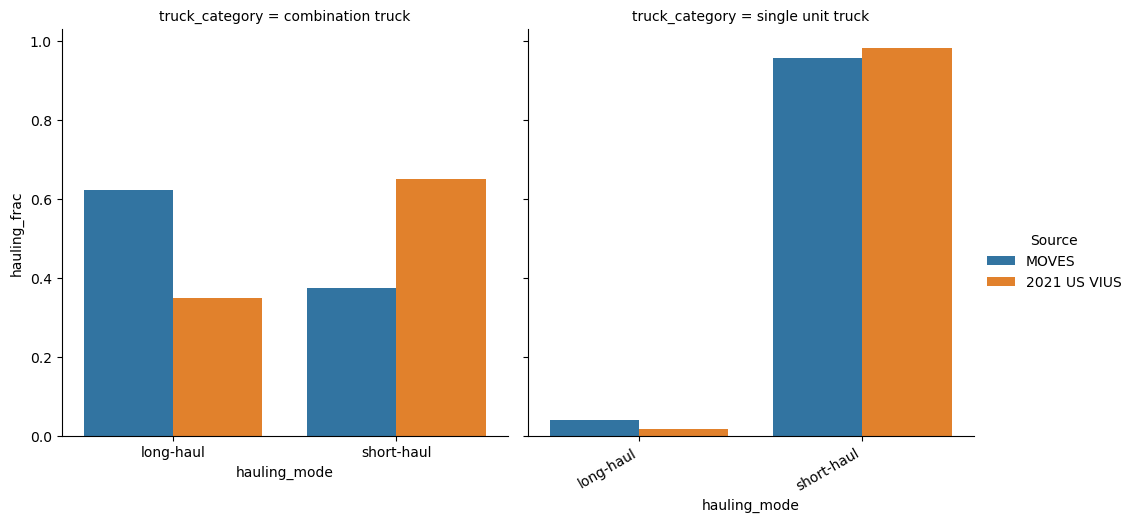

,Vehicle type,Count,Source,truck_category,hauling_mode,hauling_frac
0,combination long-haul truck,1811108.0,MOVES,combination truck,long-haul,0.623996
1,combination short-haul truck,1091325.0,MOVES,combination truck,short-haul,0.376004
3,single unit long-haul truck,383855.0,MOVES,single unit truck,long-haul,0.042241
4,single unit short-haul truck,8703350.0,MOVES,single unit truck,short-haul,0.957759
0,combination long-haul truck,742835.7,2021 US VIUS,combination truck,long-haul,0.350272
1,combination short-haul truck,1377903.0,2021 US VIUS,combination truck,short-haul,0.649728
3,single unit long-haul truck,68217.3,2021 US VIUS,single unit truck,long-haul,0.018879
4,single unit short-haul truck,3545202.2,2021 US VIUS,single unit truck,short-haul,0.981121


In [30]:
# hauling fraction by category

truck_count_comparison.loc[:, 'truck_category'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_count_comparison.loc[:, 'hauling_mode'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_count_comparison.loc[:, 'hauling_frac'] = \
truck_count_comparison.loc[:, 'Count'] /\
truck_count_comparison.groupby(['Source', 'truck_category'])['Count'].transform('sum')

sns.catplot(truck_count_comparison, 
            x="hauling_mode", y="hauling_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_hauling_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_count_comparison

In [32]:
# compare veh VMT by MOVES source type
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}
MOVES_fleet.head(5)
MOVES_VMT_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['vmt_fraction']].sum()
MOVES_VMT_by_st = MOVES_VMT_by_st.reset_index()
MOVES_VMT_by_st['sourceTypeName'] = \
MOVES_VMT_by_st['sourceTypeName'].str.lower()
print(MOVES_VMT_by_st['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['WGT_VMT']].sum()
vius_VMT_by_st = vius_VMT_by_st.reset_index()
vius_VMT_by_st['VEH_CLASS_MOVES'] = \
vius_VMT_by_st['VEH_CLASS_MOVES'].str.lower()
vius_VMT_by_st.loc[:, 'VEH_CLASS_MOVES'] = \
vius_VMT_by_st.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
MOVES_VMT_by_st.loc[:, 'Source'] = 'MOVES'

vius_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
vius_VMT_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


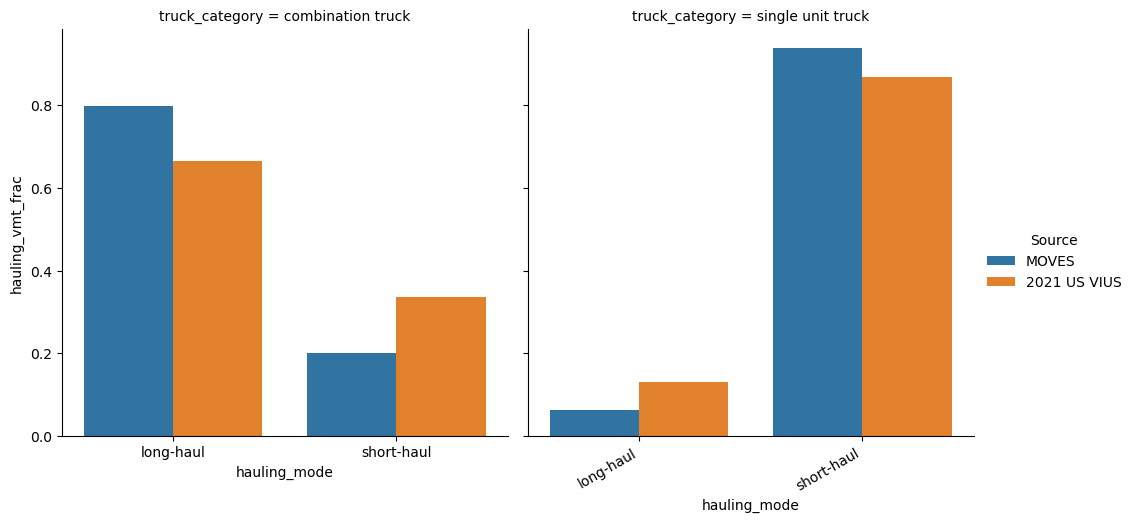

,Vehicle type,VMT rate,Source,truck_category,hauling_mode,hauling_vmt_frac
0,combination long-haul truck,7.223619e-02,MOVES,combination truck,long-haul,0.798135
1,combination short-haul truck,1.827009e-02,MOVES,combination truck,short-haul,0.201865
3,single unit long-haul truck,1.286612e-02,MOVES,single unit truck,long-haul,0.062540
4,single unit short-haul truck,1.928606e-01,MOVES,single unit truck,short-haul,0.937460
0,combination long-haul truck,8.445809e+10,2021 US VIUS,combination truck,long-haul,0.664417
1,combination short-haul truck,4.265797e+10,2021 US VIUS,combination truck,short-haul,0.335583
3,single unit long-haul truck,7.582324e+09,2021 US VIUS,single unit truck,long-haul,0.131298
4,single unit short-haul truck,5.016649e+10,2021 US VIUS,single unit truck,short-haul,0.868702


In [35]:
# hauling VMT fraction by category
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison = \
truck_VMT_comparison.loc[truck_VMT_comparison["Vehicle type"] != 
'light commercial truck']
truck_VMT_comparison.loc[:, 'truck_category'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_VMT_comparison.loc[:, 'hauling_mode'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_VMT_comparison.loc[:, 'hauling_vmt_frac'] = \
truck_VMT_comparison.loc[:, 'VMT rate'] /\
truck_VMT_comparison.groupby(['Source', 'truck_category'])['VMT rate'].transform('sum')

sns.catplot(truck_VMT_comparison, 
            x="hauling_mode", y="hauling_vmt_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_hauling_vmt_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_VMT_comparison

In [9]:
# compare veh count by MOVES source type and age bin

MOVES_fleet.head(5)
MOVES_count_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['population_by_year']].sum()
MOVES_count_by_st_age = MOVES_count_by_st_age.reset_index()
MOVES_count_by_st_age['sourceTypeName'] = \
MOVES_count_by_st_age['sourceTypeName'].str.lower()
print(MOVES_count_by_st_age['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT']].sum()
vius_count_by_st_age = vius_count_by_st_age.reset_index()
vius_count_by_st_age['VEH_CLASS_MOVES'] = \
vius_count_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_count_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_count_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
MOVES_count_by_st_age.loc[:, 'Source'] = 'MOVES'
MOVES_count_by_st_age.loc[:, 'Fraction'] = \
MOVES_count_by_st_age.loc[:, 'Fraction']/ \
MOVES_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
vius_count_by_st_age.loc[:, 'Source'] = '2021 US VIUS'
vius_count_by_st_age.loc[:, 'Fraction'] = \
vius_count_by_st_age.loc[:, 'Fraction']/ \
vius_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Age bin,Fraction,Source
0,combination long-haul truck,age<=1,0.299018,2021 US VIUS
1,combination long-haul truck,1<age<=3,0.250861,2021 US VIUS
2,combination long-haul truck,3<age<=5,0.158893,2021 US VIUS
3,combination long-haul truck,5<age<=10,0.164660,2021 US VIUS
4,combination long-haul truck,10<age<=15,0.058940,2021 US VIUS
5,combination long-haul truck,15<age<=20,0.033041,2021 US VIUS
6,combination long-haul truck,age>=20,0.034588,2021 US VIUS
7,combination short-haul truck,age<=1,0.104618,2021 US VIUS
8,combination short-haul truck,1<age<=3,0.093025,2021 US VIUS
9,combination short-haul truck,3<age<=5,0.118060,2021 US VIUS


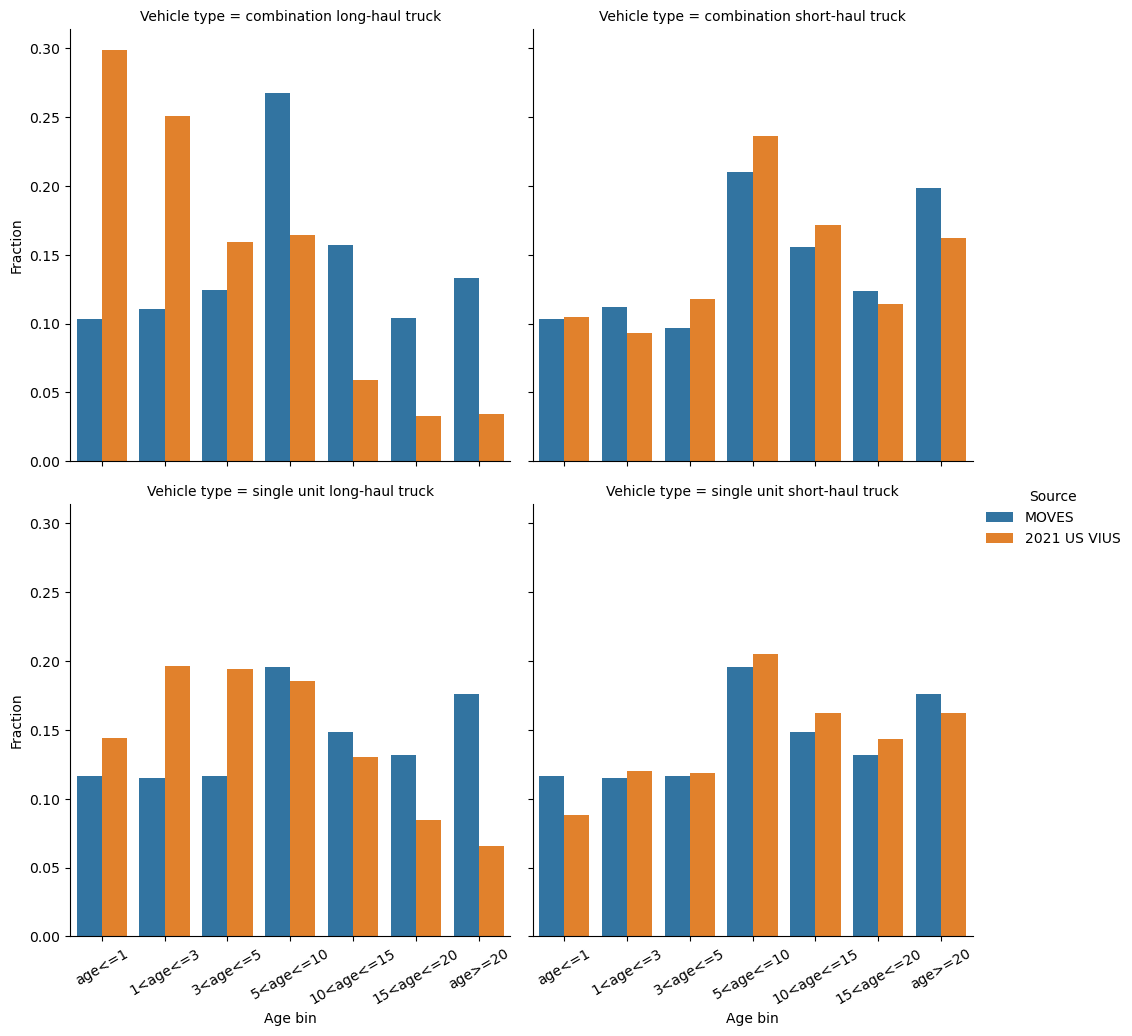

In [19]:
#plot age distribution
truck_count_comparison_by_age = \
pd.concat([MOVES_count_by_st_age, vius_count_by_st_age])
truck_count_comparison_by_age = \
truck_count_comparison_by_age.loc[truck_count_comparison_by_age["Vehicle type"] != 
'light commercial truck']
g = sns.catplot(truck_count_comparison_by_age, 
            x="Age bin", y="Fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 2)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
# compare veh VMT by MOVES source type and age bin

MOVES_fleet.head(5)
MOVES_VMT_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['vmt_fraction']].sum()
MOVES_VMT_by_st_age = MOVES_VMT_by_st_age.reset_index()
MOVES_VMT_by_st_age['sourceTypeName'] = \
MOVES_VMT_by_st_age['sourceTypeName'].str.lower()
print(MOVES_VMT_by_st_age['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['WGT_VMT']].sum()
vius_VMT_by_st_age = vius_VMT_by_st_age.reset_index()
vius_VMT_by_st_age['VEH_CLASS_MOVES'] = \
vius_VMT_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_VMT_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_VMT_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

# generate veh count comparison
MOVES_VMT_by_st_age.columns = ['Vehicle type', 'Age bin', 'VMT fraction']
MOVES_VMT_by_st_age.loc[:, 'Source'] = 'MOVES'
MOVES_VMT_by_st_age.loc[:, 'VMT fraction'] = \
MOVES_VMT_by_st_age.loc[:, 'VMT fraction']/ \
MOVES_VMT_by_st_age.groupby('Vehicle type')['VMT fraction'].transform('sum')

vius_VMT_by_st_age.columns = ['Vehicle type', 'Age bin', 'VMT fraction']
vius_VMT_by_st_age.loc[:, 'Source'] = '2021 US VIUS'
vius_VMT_by_st_age.loc[:, 'VMT fraction'] = \
vius_VMT_by_st_age.loc[:, 'VMT fraction']/ \
vius_VMT_by_st_age.groupby('Vehicle type')['VMT fraction'].transform('sum')

vius_VMT_by_st_age

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Age bin,VMT fraction,Source
0,combination long-haul truck,age<=1,0.313102,2021 US VIUS
1,combination long-haul truck,1<age<=3,0.245373,2021 US VIUS
2,combination long-haul truck,3<age<=5,0.153186,2021 US VIUS
3,combination long-haul truck,5<age<=10,0.154892,2021 US VIUS
4,combination long-haul truck,10<age<=15,0.067137,2021 US VIUS
5,combination long-haul truck,15<age<=20,0.030520,2021 US VIUS
6,combination long-haul truck,age>=20,0.035791,2021 US VIUS
7,combination short-haul truck,age<=1,0.137808,2021 US VIUS
8,combination short-haul truck,1<age<=3,0.128686,2021 US VIUS
9,combination short-haul truck,3<age<=5,0.157986,2021 US VIUS


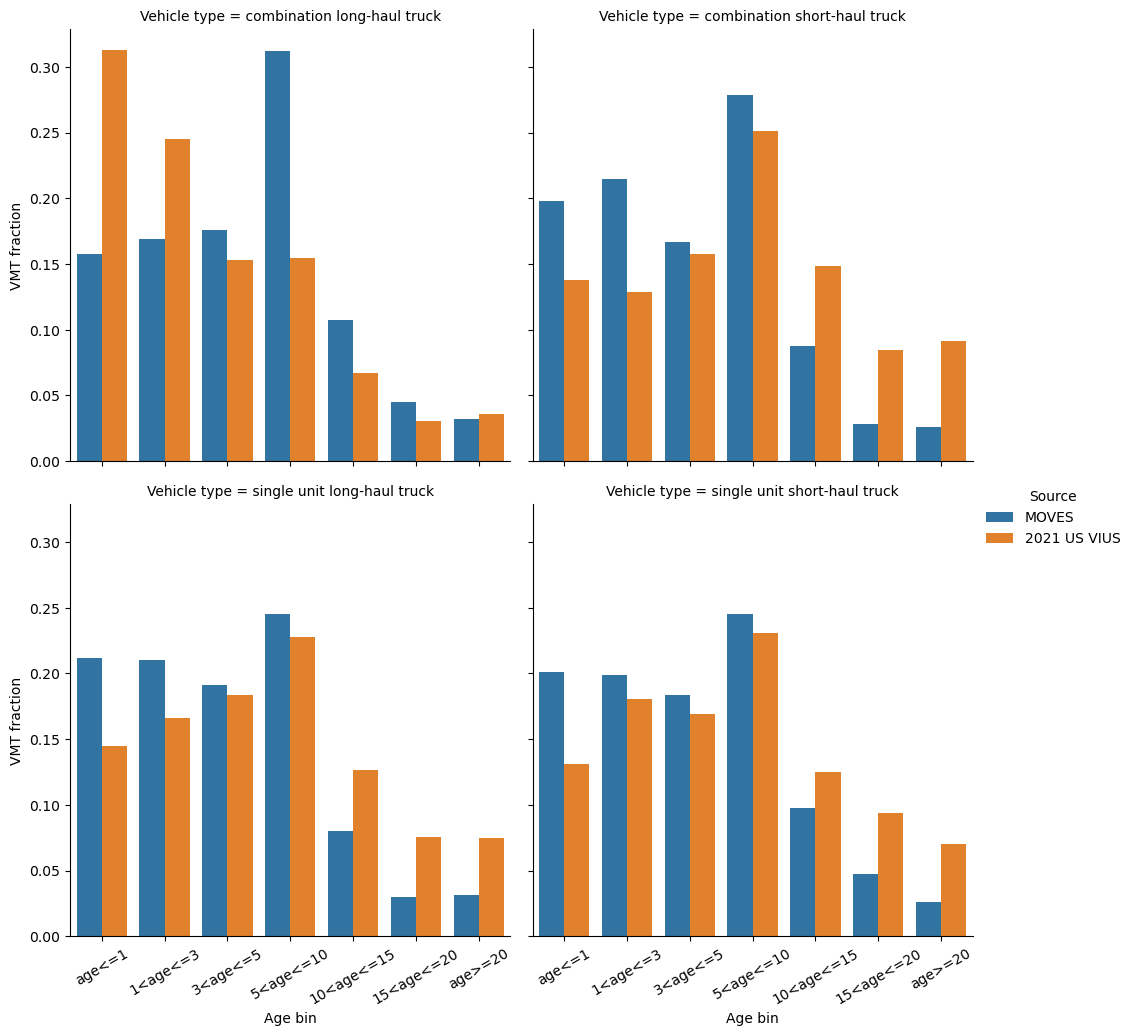

In [18]:
#plot age distribution BY vmt
truck_VMT_comparison_by_age = \
pd.concat([MOVES_VMT_by_st_age, vius_VMT_by_st_age])
truck_VMT_comparison_by_age = \
truck_VMT_comparison_by_age.loc[truck_VMT_comparison_by_age["Vehicle type"] != 
'light commercial truck']
g = sns.catplot(truck_VMT_comparison_by_age, 
            x="Age bin", y="VMT fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 2)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

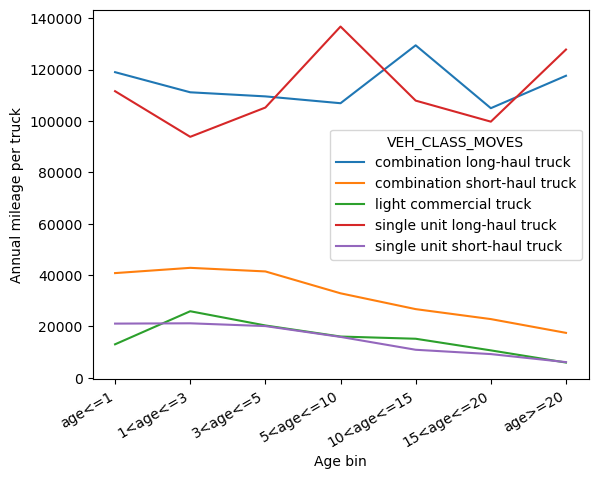

In [24]:
# VIUS VMT/truck

vius_stats_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT','WGT_VMT']].sum()
vius_stats_by_st_age = vius_stats_by_st_age.reset_index()
vius_stats_by_st_age['VEH_CLASS_MOVES'] = \
vius_stats_by_st_age['VEH_CLASS_MOVES'].str.lower()
vius_stats_by_st_age.loc[:, 'VEH_CLASS_MOVES'] = \
vius_stats_by_st_age.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)


vius_stats_by_st_age.loc[:, 'ANNUAL_MILE_PER_TRUCK'] = \
vius_stats_by_st_age.loc[:, 'WGT_VMT'] / \
vius_stats_by_st_age.loc[:, 'TABWEIGHT']
sns.lineplot(vius_stats_by_st_age, 
            x="AGE_BIN", y="ANNUAL_MILE_PER_TRUCK", 
            hue="VEH_CLASS_MOVES", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.savefig('RawData/MOVES/plot/VIUS_VMT_per_truck_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

Text(78.44658333333332, 0.5, 'Annual mileage per truck')

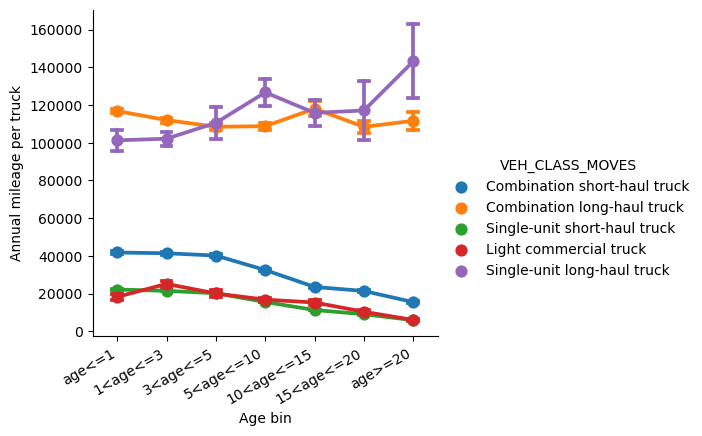

In [31]:
sns.catplot(x="AGE_BIN", y="MILESANNL",
             hue="VEH_CLASS_MOVES", 
             data=vius_fleet, capsize=.2, 
            errorbar="se", kind="point", height=4, aspect=1.25,)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')